# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Описание данных

+ **id** — уникальный идентификатор скважины
+ **f0, f1, f2** — три признака точек (неважно, что они означают, но сами признаки значимы)
+ **product** — объём запасов в скважине (тыс. баррелей)

**Данные геологоразведки трёх регионов находятся в файлах:**

+ **/datasets/geo_data_0.csv**
+ **/datasets/geo_data_1.csv**
+ **/datasets/geo_data_2.csv**

**Условия задачи**
+ Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые)
+ При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки
+ Бюджет на разработку скважин в регионе — 10 млрд рублей
+ При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей
+ После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью

## Загрузка и подготовка данных

In [37]:
!pip install phik

In [38]:
import pandas as pd
from sklearn.linear_model import LinearRegression
import numpy as np
import matplotlib.pyplot as plt
import itertools
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
import phik
from numpy.random import RandomState

In [39]:
RANDOM_STATE = 42

In [40]:
geo_data_0 = pd.read_csv('/datasets/geo_data_0.csv')
geo_data_0.head(10)

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647
5,wX4Hy,0.969570,0.489775,-0.735383,64.741541
6,tL6pL,0.645075,0.530656,1.780266,49.055285
7,BYPU6,-0.400648,0.808337,-5.624670,72.943292
8,j9Oui,0.643105,-0.551583,2.372141,113.356160
9,OLuZU,2.173381,0.563698,9.441852,127.910945


In [41]:
geo_data_1 = pd.read_csv('/datasets/geo_data_1.csv', sep=',')
geo_data_1.head(10)

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305
5,HHckp,-3.327590,-2.205276,3.003647,84.038886
6,h5Ujo,-11.142655,-10.133399,4.002382,110.992147
7,muH9x,4.234715,-0.001354,2.004588,53.906522
8,YiRkx,13.355129,-0.332068,4.998647,134.766305
9,jG6Gi,1.069227,-11.025667,4.997844,137.945408


In [42]:
geo_data_2 = pd.read_csv('/datasets/geo_data_2.csv')
geo_data_2.head(10)

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746
5,LzZXx,-0.758092,0.710691,2.585887,90.222465
6,WBHRv,-0.574891,0.317727,1.773745,45.641478
7,XO8fn,-1.906649,-2.458350,-0.177097,72.480640
8,ybmQ5,1.776292,-0.279356,3.004156,106.616832
9,OilcN,-1.214452,-0.439314,5.922514,52.954532


### Предобработка столбца geo_data_0

In [43]:
geo_data_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [44]:
geo_data_0.describe().T

,count,mean,std,min,25%,50%,75%,max
f0,100000.0,0.500419,0.871832,-1.408605,-0.072580,0.502360,1.073581,2.362331
f1,100000.0,0.250143,0.504433,-0.848218,-0.200881,0.250252,0.700646,1.343769
f2,100000.0,2.502647,3.248248,-12.088328,0.287748,2.515969,4.715088,16.003790
product,100000.0,92.500000,44.288691,0.000000,56.497507,91.849972,128.564089,185.364347


In [45]:
geo_data_0.isna().sum()

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

Пропусков в данных нет, оценим дубликаты 

In [46]:
geo_data_0.duplicated().sum()

0

Дубликатов в данных нет, но уточнить, фигурирует ли **id** для одной скважины несколько раз

In [47]:
geo_data_0.duplicated(['id']).sum()

10

In [48]:
duplicate_id = geo_data_0[geo_data_0.duplicated(['id'])]
id_duplicate = duplicate_id['id'].unique()
dupl = geo_data_0.loc[geo_data_0['id'].isin(id_duplicate)].sort_values(by = 'id', ascending = False)
display(dupl)

,id,f0,f1,f2,product
90815,fiKDv,0.049883,0.841313,6.394613,137.346586
16633,fiKDv,0.157341,1.028359,5.585586,95.817889
41724,bxg6G,-0.823752,0.546319,3.630479,93.007798
1364,bxg6G,0.411645,0.856830,-3.653440,73.604260
97785,bsk9y,0.378429,0.005837,0.160827,160.637302
89582,bsk9y,0.398908,-0.400253,10.122376,163.433078
92341,TtcGQ,0.110711,1.022689,0.911381,101.318008
60140,TtcGQ,0.569276,-0.104876,6.440215,85.350186
21426,Tdehs,0.829407,0.298807,-0.049563,96.035308
75715,Tdehs,0.112079,0.430296,3.218993,60.964018


In [49]:
geo_data_0 = pd.read_csv('/datasets/geo_data_0.csv', index_col='id')

Мы можем выгрузить из нашего исходного датасета этот список и удалить дубликаты путем добавления к одному и тому же **id** порядковым номеров **1** и **2** соотвественно, но таких аномалий очень мало, поэтому смысла в этом немного

### Предобработка столбца geo_data_1

In [50]:
geo_data_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [51]:
geo_data_1.describe().T

,count,mean,std,min,25%,50%,75%,max
f0,100000.0,1.141296,8.965932,-31.609576,-6.298551,1.153055,8.621015,29.421755
f1,100000.0,-4.796579,5.119872,-26.358598,-8.267985,-4.813172,-1.332816,18.734063
f2,100000.0,2.494541,1.703572,-0.018144,1.000021,2.011479,3.999904,5.019721
product,100000.0,68.825000,45.944423,0.000000,26.953261,57.085625,107.813044,137.945408


In [52]:
geo_data_1.isna().sum()

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

In [53]:
geo_data_1.duplicated(['id']).sum()

4

In [54]:
geo_data_1 = pd.read_csv('/datasets/geo_data_1.csv', index_col='id')

Аналогично предыдущему столбцу 

### Предобработка столбца geo_data_1

In [55]:
geo_data_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [56]:
geo_data_2.describe().T

,count,mean,std,min,25%,50%,75%,max
f0,100000.0,0.002023,1.732045,-8.760004,-1.162288,0.009424,1.158535,7.238262
f1,100000.0,-0.002081,1.730417,-7.084020,-1.174820,-0.009482,1.163678,7.844801
f2,100000.0,2.495128,3.473445,-11.970335,0.130359,2.484236,4.858794,16.739402
product,100000.0,95.000000,44.749921,0.000000,59.450441,94.925613,130.595027,190.029838


In [57]:
geo_data_2.duplicated().sum()

0

In [58]:
geo_data_2.duplicated(['id']).sum()

4

Теперь, когда мы проанализировали и обработали наши датасеты, мы можем перейти к визуализации и анализу данных 

In [59]:
geo_data_2 = pd.read_csv('/datasets/geo_data_2.csv', index_col='id')

Построение **boxplot**-графиков

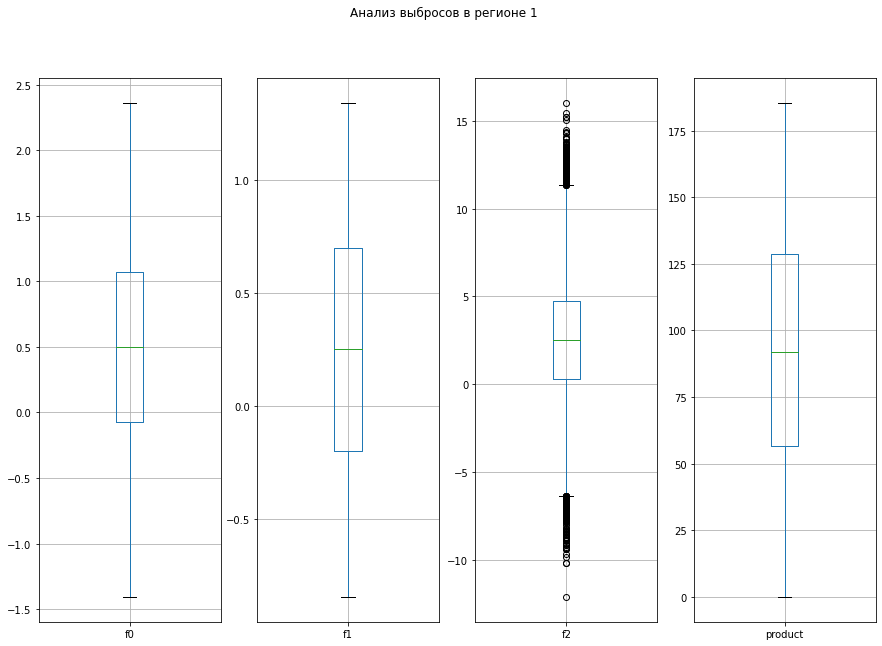

In [60]:
fig, axes = plt.subplots(1, 4, figsize=(15, 10))

geo_data_0.boxplot('f0', ax=axes[0])
geo_data_0.boxplot('f1', ax=axes[1])
geo_data_0.boxplot('f2', ax=axes[2])
geo_data_0.boxplot('product', ax=axes[3])

fig.suptitle('Анализ выбросов в регионе 1')

plt.show()

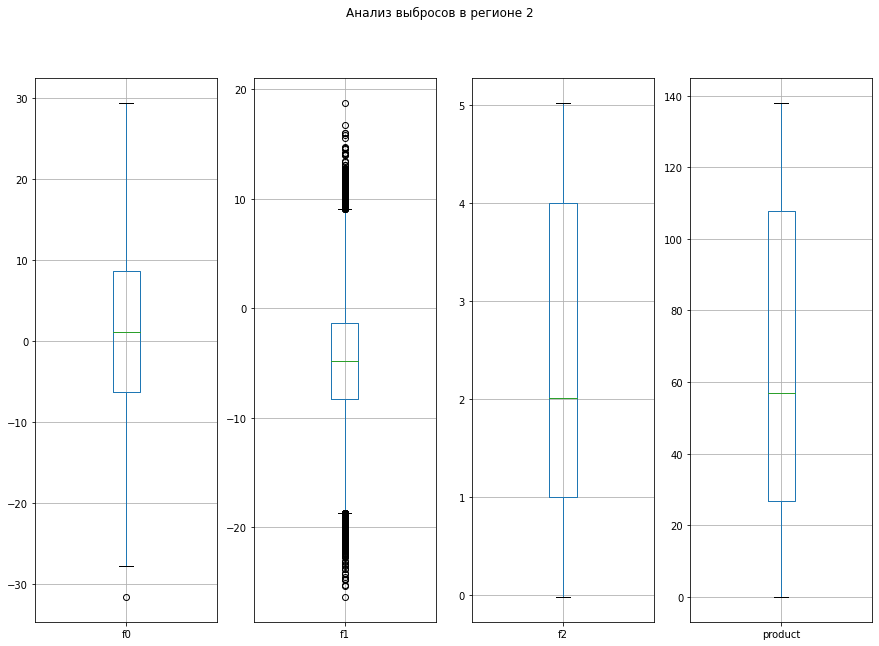

In [61]:
fig, axes = plt.subplots(1, 4, figsize=(15, 10))

geo_data_1.boxplot('f0', ax=axes[0])
geo_data_1.boxplot('f1', ax=axes[1])
geo_data_1.boxplot('f2', ax=axes[2])
geo_data_1.boxplot('product', ax=axes[3])

fig.suptitle('Анализ выбросов в регионе 2')

plt.show()

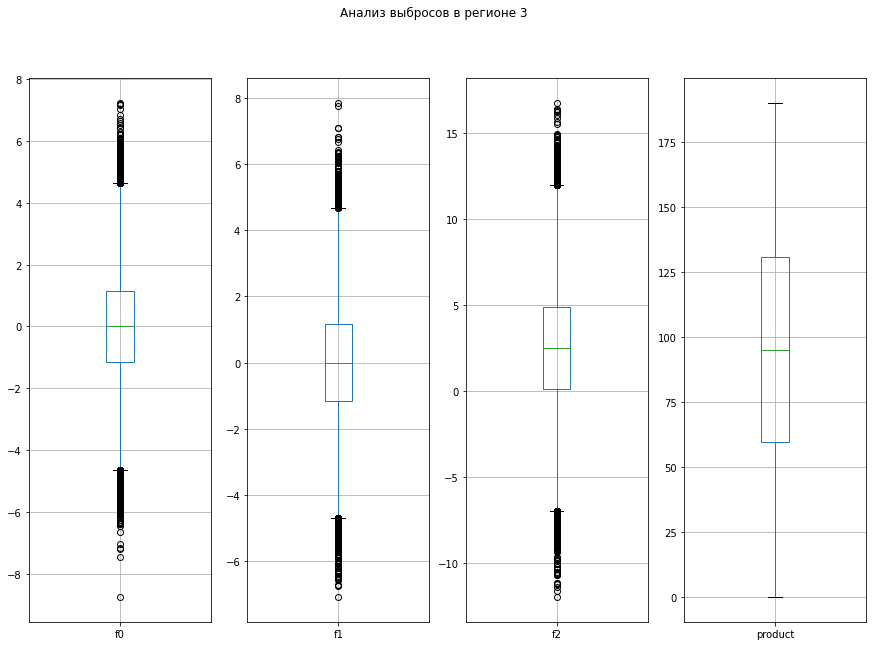

In [62]:
fig, axes = plt.subplots(1, 4, figsize=(15, 10))

geo_data_2.boxplot('f0', ax=axes[0])
geo_data_2.boxplot('f1', ax=axes[1])
geo_data_2.boxplot('f2', ax=axes[2])
geo_data_2.boxplot('product', ax=axes[3])

fig.suptitle('Анализ выбросов в регионе 3')

plt.show()

Комментировать заданные нам метрики смысла не имеет, так как мы не знаем что они значат, мы лишь знаем что они важны, однако что касается признака **product**, то он лучше всего у скважины в регионе 3, так как у нее самое высокое медианное значение.

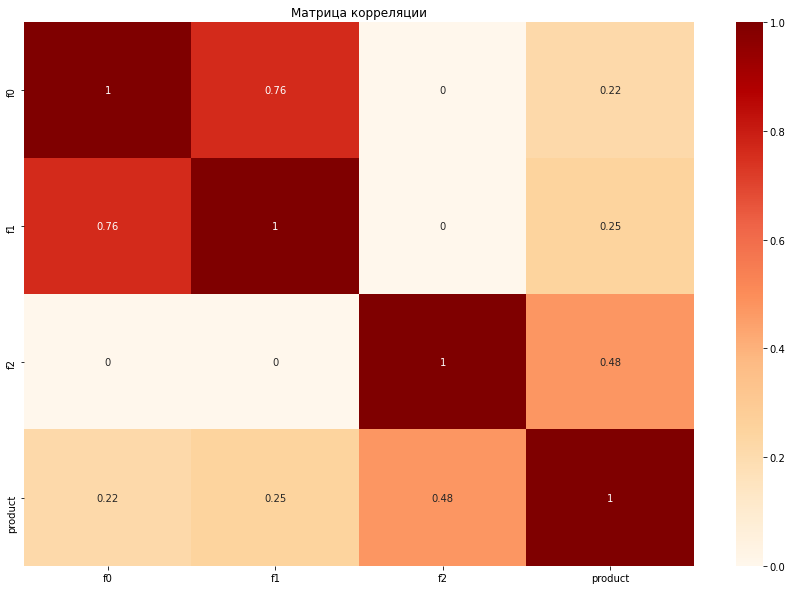

In [63]:
def corr_analitica(data):
    interval_cols = ['f0', 'f1', 'f2', 'product'] 
    corr_matrix = data.phik_matrix(interval_cols=interval_cols)
    plt.figure(figsize=(15, 10))
    sns.heatmap(corr_matrix, annot=True, cmap='OrRd')
    plt.title('Матрица корреляции')
    plt.show()
corr_analitica(geo_data_0)

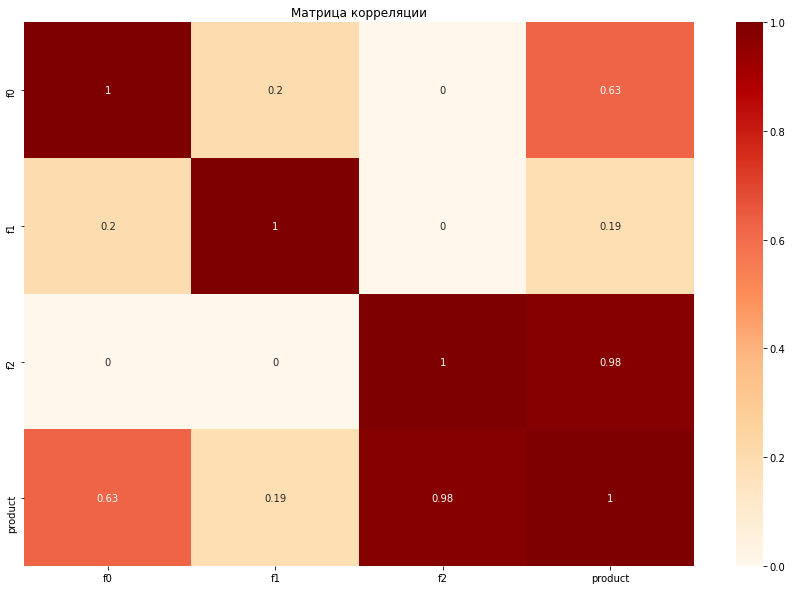

In [64]:
corr_analitica(geo_data_1)

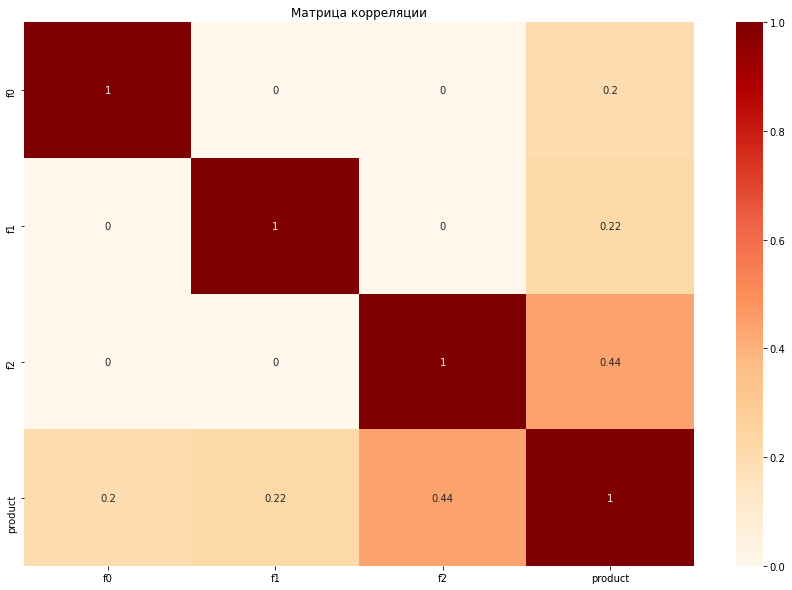

In [65]:
corr_analitica(geo_data_2)

Как мы можем видеть, в данных с 1 и 2 участков мультиколлинеарность достигает наибольшего масштаба, 3 участок выглядит лучше всего. Так как данные эти очень важны и запросить повторный сбор информации мы не можем, работаем с тем что есть.

## Обучение и проверка модели

Теперь нам необходимо подготовить наши данные, выделим целевые признаки

In [66]:
features_0_geo = geo_data_0.drop('product', axis=1)
features_1_geo = geo_data_1.drop('product', axis=1)
features_2_geo = geo_data_2.drop('product', axis=1)

target_0_geo = geo_data_0['product']
target_1_geo = geo_data_1['product']
target_2_geo = geo_data_2['product']

Теперь пришло время к обучение модели. Так как у нас три идентичных датасета, то намного оптимальнее было бы написать функцию для обучения модели машинного обучения. Также следует отметить, что для обучения модели будет использоваться только линейная регрессия (остальные — недостаточно предсказуемые).

In [67]:
def machine_learning(features, target, region): 
    features_train, features_valid, target_train, target_valid = train_test_split(
        features,
        target,
        random_state=42,
        test_size=0.25,
    )
    scaler = StandardScaler()
    numerics = ['f0', 'f1', 'f2']
    features_train[numerics] = scaler.fit_transform(features_train[numerics])
    features_valid[numerics] = scaler.transform(features_valid[numerics])
    
    model = LinearRegression()
    model.fit(features_train, target_train)
    predicted = model.predict(features_valid)
    
    print(f'Средний запас сырья в {region}:', predicted.mean())
    print('RMSE модели:', mean_squared_error(target_valid, predicted, squared=False))
    print('------')
    
    df = pd.DataFrame([], columns=['correct', 'predicted'])
    df['correct'] = target_valid
    df['predicted'] = predicted
    
    return pd.Series(predicted), pd.Series(target_valid), df

In [68]:
predicted_0_geo, correct_0_geo, df_0_geo = machine_learning(features_0_geo, target_0_geo, 'first_region')
predicted_1_geo, correct_1_geo, df_1_geo = machine_learning(features_1_geo, target_1_geo, 'second_region')
predicted_2_geo, correct_2_geo, df_2_geo = machine_learning(features_2_geo, target_2_geo, 'third_region')

predicted_0_geo.index = correct_0_geo.index
predicted_1_geo.index = correct_1_geo.index
predicted_2_geo.index = correct_2_geo.index

/tmp/ipykernel_511/1207026698.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_train[numerics] = scaler.fit_transform(features_train[numerics])
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_

Средний запас сырья в first_region: 92.39879990657768
RMSE модели: 37.75660035026169
------
Средний запас сырья в second_region: 68.7128780391376
RMSE модели: 0.8902801001028846
------


/tmp/ipykernel_511/1207026698.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_train[numerics] = scaler.fit_transform(features_train[numerics])
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_

Средний запас сырья в third_region: 94.77102387765939
RMSE модели: 40.145872311342174
------


/tmp/ipykernel_511/1207026698.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_train[numerics] = scaler.fit_transform(features_train[numerics])
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_

**Лучший результат для нас:**
+ Средний запас сырья в third_region: 94.77102387765939

Теперь посмотрим размерность датафреймов и выведем их

In [69]:
display(predicted_0_geo.shape)
display(correct_0_geo.shape)
display(df_0_geo.head())

(25000,)

(25000,)

,correct,predicted
id,,
7C6bA,122.073350,101.901017
dVxsn,48.738540,78.217774
1Gm3l,131.338088,115.266901
Nzg1t,88.327757,105.618618
Z7b4F,36.959266,97.980185


## Подготовка к расчёту прибыли

Введем константные значения

In [70]:
BUDGET = 10_000_000_000  # бюджет, выделенный на разработку скважин
PRICE = 450_000  # доход за продажу с единицы продукта
N = 200  # количество скважин для разработки
WELLS_COUNT = 500 # Всего кол-во исследуемых точек

n = (BUDGET / N) / PRICE
print(f'Достаточный объём сырья для безубыточной разработки новой скважины: {n}.')

Достаточный объём сырья для безубыточной разработки новой скважины: 111.11111111111111.


Cоздадим функцию для рассчета прибыли

In [79]:
def cost_count(subsample, INCOME_FROM_ONE_UNIT, TOTAL_BUDGET):
    top_200 = subsample.sort_values('predictions', ascending=False).head(200)
    selected_targets = top_200['target']
    income = selected_targets.sum() * INCOME_FROM_ONE_UNIT
    profit = income - TOTAL_BUDGET
    return profit
    # КОД РЕВЬЮЕРА, debug
    if selected.shape[0] != 200:
        print(f'Shape mismatch! You took {selected.shape[0]} target values')
    return profit
    return selected.sum() * INCOME_FROM_ONE_UNIT - TOTAL_BUDGET

In [80]:
# КОД РЕВЬЮЕРА
# предположим, у нас есть небольшой сэмпл из 5 предсказаний и 5 соответствующих таргетов
_target = pd.Series([2, 2, 3, 3, 3], index=[2, 2, 3, 3, 3])
_preds = pd.Series([2, 2, 3, 3, 3], index=[2, 2, 3, 3, 3]).sort_values(ascending=False)
# берём таргеты по индексам предсказаний:
display(_target.loc[_preds.index])

3    3
3    3
3    3
3    3
3    3
3    3
3    3
3    3
3    3
2    2
2    2
2    2
2    2
dtype: int64

+ Мы ввели основные константы, необходимые для рассчета прибыльности вышки
+ Вычислили необходимый объем сырья для безубыточности скважины. При этом самая прибыльная из трех скважин не дотягивает для этого показателя 
+ Создали функцию для подсчета прибыли в 200 отобранных скважин

## Расчёт прибыли и рисков 

In [81]:
def bootstrap(target, predictions, INCOME_FROM_ONE_UNIT, TOTAL_BUDGET, region):
    state = np.random.RandomState(42)
    values = []

    df = pd.DataFrame({'target': target, 'predictions': predictions})
     
    for i in range(1000):
        subsample = df.sample(n=WELLS_COUNT, replace=True, random_state=state)
        profit = cost_count(subsample, INCOME_FROM_ONE_UNIT, TOTAL_BUDGET)
        values.append(profit)

    values = pd.Series(values)
    mean_profit = values.mean()
    lower = values.quantile(0.025)
    upper = values.quantile(0.975)
    
    print(f'ДЛЯ РЕГИОНА {region.upper()}:')
    print('Средняя прибыль:', mean_profit / 1000000, 'млн')
    print('Нижняя граница:', lower / 1000000, 'млн')
    print('Верхняя граница:', upper / 1000000, 'млн')
    print(f'Риск убытка: {(len(values[values < 0]) / len(values)):.2%}')
    print('---')
    
    fig, ax1 = plt.subplots(figsize=(8, 5))
    fig.suptitle(f'Распределение прибыли (регион {region})', fontsize=14)
    
    sns.boxplot(x=values / 1e6, ax=ax1, color='skyblue')
    ax1.set_xlabel('Прибыль (млн $)')
    ax1.axvline(mean_profit / 1e6, color='red', linestyle='--', label=f'Среднее: {mean_profit / 1e6:.2f} млн $')
    ax1.legend()
    plt.tight_layout()
    plt.show()

In [82]:
df = pd.DataFrame({'target': correct_0_geo, 'predictions': predicted_0_geo})
ss = df.sample(n=1000, replace=True, random_state=np.random.RandomState(42))

In [83]:
ss.index.nunique()

981

ДЛЯ РЕГИОНА ОДИН:
Средняя прибыль: 399.57547805422973 млн
Нижняя граница: -110.46789533197226 млн
Верхняя граница: 897.4603277178793 млн
Риск убытка: 6.00%
---


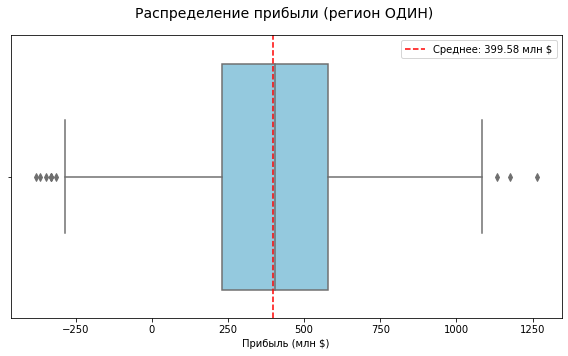

ДЛЯ РЕГИОНА ДВА:
Средняя прибыль: 452.0488909064583 млн
Нижняя граница: 61.68447965422669 млн
Верхняя граница: 845.3401775073847 млн
Риск убытка: 1.50%
---


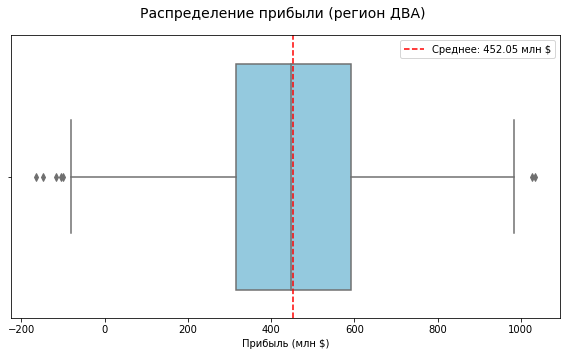

ДЛЯ РЕГИОНА ТРИ:
Средняя прибыль: 375.009902915329 млн
Нижняя граница: -144.7667273048927 млн
Верхняя граница: 888.3904035342213 млн
Риск убытка: 8.00%
---


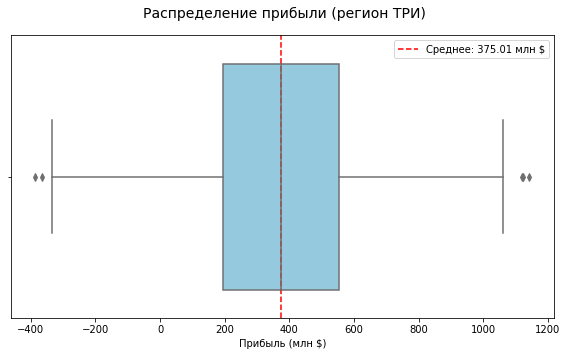

In [84]:
bootstrap(correct_0_geo, predicted_0_geo, PRICE, BUDGET, 'ОДИН')
bootstrap(correct_1_geo, predicted_1_geo, PRICE, BUDGET, 'ДВА')
bootstrap(correct_2_geo, predicted_2_geo, PRICE, BUDGET, 'ТРИ')

Итак, мы теперь можем окончательно 2 регион как самый прибыльный по следующим причинам:
+ Минимальный риск убытка (который удовлетворяет условиям заказчика, **<2.5%**
+ Наибольшая прибыль **составляет 452 млн)**
+ Лучшие границы прибыли (с вероятности в 95% попадаем в интервал) 

## Итоговый вывод

В результате исследования была построена модель машинного обучения, способная определить регион, где добыча принесет наибольшую прибыль. В ходе анализа рисков и прибыли при помощи метода Bootstrap были сделаны следующие выводы:

Рекомендация по выбору региона - **регион 2**
+ В нем предсказан наименьший риск убытков - **1.5%** (который удовлетворяет условиям заказчика) 
+ Регион может в среднем принести **~452 млн прибыли**
